In [ ]:
#This just widens the ares of Jupyter notebook
from IPython.core.display import display,HTML
display(HTML("<style>.container {width:90% !important; }</style>"))

# NLP Toolkit
A number of functions desinged to give a low barrier of entry to lots of Natural Lanuguage Processing functions and display options.

A typical use case would be being asked (as the Analytics point of contact) to analyse a spreadsheet of survey comments; a task that you do not want to devote weeks of effort to, but that it would be good to throw some cutting edge analytics at to showcase what we can do.

Not designed to be used for a specific NLP assignment for deploying models to the cloud. This is for quick and dirty NLP on dataframes.

## What we are aiming for
Some useful visualisations and interactive tools to help us get a sense about what is being talked about in a selection of (typicall short) comments. We will produce much simpler plots than shown below.

### Using Scattertext to show which words are associated between two groups or characteristics

<img src="scattertext_large_plot.png" width="75%">

### Using UMAP to reduce our knowledge of words into a 2D space to visualise clusters of similarity
<img src="umap_large_plot.png" width="75%">

### Using Tiddlywiki to produce an interactive tool to show word associations within our corpus
<img src="tiddler_keyword_pic.png" width="75%">


### And some wordclouds!
<img src="wordcloud.png">

## How we will do it: Modifying Pandas with NLP functions
We use the pandas_flavor package together with the @pandas_flavor.register_dataframe_method decorator to allow us to pipe NLP processing steps onto the dataframe

For example:
```python
df.nlp_extract_sentiment('comments').nlp_extract_entities('comments')
```

The details and what NLP libraries are being used are hidden from the user, this makes it very quick to apply.

## Packages we need


In [ ]:
import pandas_flavor as pf
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from itertools import repeat
import networkx as nx
import janitor as jn
import numpy as np
import json
import gensim
import pyLDAvis.gensim
import nltk
import spacy
from spacy.matcher import Matcher
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from functools import reduce
from scipy.stats import zscore
import scattertext as st
# import umap
# import umap.plot
from bokeh.plotting import output_file, save
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pysnooper


pd.options.display.max_colwidth=300 #this will let us see the comments
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
#!python -m spacy download en_core_web_md #this needed to download the spacy language model

## Download and initialise the various NLP models
Note we are using the medium NLP model which has word vectors which we will need later.

In [ ]:
from nlp_toolkit import * #this is the code I wrote
nlp = spacy.load('en_core_web_md') # our main language understanding model
matcher = Matcher(nlp.vocab) # a python object to store word matches - although we won't use this in this notebook

## Importing a spreadsheet of comments
We'll have a really simple spreadsheet of only 7 comments. The read_dataframe method is called everytime for each example. This is so you can modify the spreadsheet and see changes in the specific example you are working on, without having to run every cell in this notebook after each change to the spreadsheet.

In [65]:
def read_dataframe(file = 'nlp_simple_comments.xlsx', sheet_index=0):
    return pd.read_excel(file, sheet_name=sheet_index)

df = read_dataframe()
df.head(10)

,person,good_week,comment
0,family,1,I really liked the dogs
1,solo,1,wolves were fantastic
2,family,1,cats were great
3,solo,1,what amazing felines
4,family,0,the food was not great
5,solo,0,I didn't like the sandwiches
6,solo,0,Dave said drinks were OK
7,family,1,"I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!"


## Pre-processing
First we apply a natural language model onto the comment columns, using our nlp object we defined at the beginning.

Note the defaults in the function call tell it to produce another dataframe column called 'nlp'

In [66]:
(
      read_dataframe()
      .nlp_process_column(column_name = 'comment',
                          nlp_object = nlp,
                          new_column_name = 'nlp'
                         )
)


,person,good_week,comment,nlp
0,family,1,I really liked the dogs,"(I, really, liked, the, dogs)"
1,solo,1,wolves were fantastic,"(wolves, were, fantastic)"
2,family,1,cats were great,"(cats, were, great)"
3,solo,1,what amazing felines,"(what, amazing, felines)"
4,family,0,the food was not great,"(the, food, was, not, great)"
5,solo,0,I didn't like the sandwiches,"(I, did, n't, like, the, sandwiches)"
6,solo,0,Dave said drinks were OK,"(Dave, said, drinks, were, OK)"
7,family,1,"I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!","(I, saw, a, few, cats, when, I, was, there, and, that, was, pretty, amazing, ,, I, do, love, cats, that, 's, why, !)"


### Lemmatisation and stop word removal
We can quickly remove stop words and lemmatise the text, however negations aren't coming through as these are a stop word, we can avoid this with the keep= paramater. Keep will accept specific words or spacy dependency keywords, such as neg (NEGATION)

In [67]:
(
      read_dataframe()
        .nlp_process_column(
            column_name = 'comment',
            nlp_object = nlp,
            new_column_name = 'nlp'
                            )
        .nlp_extract_lemma_text(
            nlp_column = 'nlp',
            new_column_name = 'lemma_sentences',
                               )
)



,person,good_week,comment,nlp,lemma_sentences
0,family,1,I really liked the dogs,"(I, really, liked, the, dogs)",like dog
1,solo,1,wolves were fantastic,"(wolves, were, fantastic)",wolf fantastic
2,family,1,cats were great,"(cats, were, great)",cat great
3,solo,1,what amazing felines,"(what, amazing, felines)",amazing feline
4,family,0,the food was not great,"(the, food, was, not, great)",food great
5,solo,0,I didn't like the sandwiches,"(I, did, n't, like, the, sandwiches)",like sandwich
6,solo,0,Dave said drinks were OK,"(Dave, said, drinks, were, OK)",Dave say drink ok
7,family,1,"I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!","(I, saw, a, few, cats, when, I, was, there, and, that, was, pretty, amazing, ,, I, do, love, cats, that, 's, why, !)",see cat pretty amazing love cat


In [70]:
(
      read_dataframe()
        .nlp_process_column(
            column_name = 'comment',
            nlp_object = nlp,
            new_column_name = 'nlp'
                            )
        .nlp_extract_lemma_text(
            nlp_column = 'nlp',
            new_column_name = 'lemma_sentences',
            keep = ['neg']
                               )
        .select_columns(['comment','lemma_sentences'])
)



,comment,lemma_sentences
0,I really liked the dogs,like dog
1,wolves were fantastic,wolf fantastic
2,cats were great,cat great
3,what amazing felines,amazing feline
4,the food was not great,food not great
5,I didn't like the sandwiches,not like sandwich
6,Dave said drinks were OK,Dave say drink ok
7,"I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!",see cat pretty amazing love cat


## Back to our original example - Sentiment Analysis
We use the NLTK sentiment model here and it's done a reasonable job.

In [79]:
(
    read_dataframe()
    .nlp_extract_sentiment('comment')
    .sort_values(by='sentiment', ascending=False)
)



,person,good_week,comment,sentiment
7,family,1,"the food was not great I didn't like the sandwiches I didn't like the sandwiches I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!I saw a few cats when I was there and...",0.99
2,family,1,cats were great,0.62
3,solo,1,what amazing felines,0.59
1,solo,1,wolves were fantastic,0.56
0,family,1,I really liked the dogs,0.48
6,solo,0,Dave said drinks were OK,0.45
5,solo,0,I didn't like the sandwiches,-0.28
4,family,0,the food was not great,-0.51


## Parts of speech
We may want to pull out parts of speech, a useful way to analyse small comments is comparing sentiment to nouns. What things to people talk about in positive vs. negative sentiment?

The nlp_extract_pos function will accept a list of parts-of-speech or dependencies (see Spacy documentation for the correct strings to use)

In [72]:

(
      read_dataframe()
        .nlp_process_column(
            column_name = 'comment',
            nlp_object = nlp,
            new_column_name = 'nlp'
                            )
        .nlp_extract_pos(
            nlp_column = 'nlp',
            token_pos = ['NOUN'],
            new_column_name = 'pos',
            lemma = True
                        )

        .select_columns(['comment','pos'])
)


,comment,pos
0,I really liked the dogs,[dog]
1,wolves were fantastic,[wolf]
2,cats were great,[cat]
3,what amazing felines,[feline]
4,the food was not great,[food]
5,I didn't like the sandwiches,[sandwich]
6,Dave said drinks were OK,[drink]
7,"I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!","[cat, cat]"


## Automatic topic analysis - TFIDF
We've found TFIDF to be much better than LDA to obtain topics from short comments. This makes sense as the whole premise of LDA is that documents are made up of muliple topics, whereas brief survey comments are often just one topic.

The defaults bring out a reasonable number of keywords that seem to capture what the person was talking about and some degree of meaning such as 'like dog'

This is useful when plotting keyword co-occurences

In [76]:

(
      read_dataframe()
        .nlp_process_column(
            column_name = 'comment',
            nlp_object = nlp,
            new_column_name = 'nlp'
                            )
        .nlp_extract_lemma_text(
            nlp_column = 'nlp',
            new_column_name = 'lemma_sentences',
            keep = ['neg']
                               )
        .nlp_apply_tfidf(
            column_name = 'lemma_sentences',
            threshold = 0.3,
            top_n = 1,
            new_column_name = 'keywords',
        append=True)
    
       # .select_columns(['comment','lemma_sentences', 'keywords'])
)


,person,good_week,comment,nlp,lemma_sentences,keywords,amazing,cat,dave,dog,...,great,like,love,not,ok,pretty,sandwich,say,see,wolf
0,family,1,I really liked the dogs,"(I, really, liked, the, dogs)",like dog,{dog},0.00,0.00,0.00,0.77,...,0.00,0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,solo,1,wolves were fantastic,"(wolves, were, fantastic)",wolf fantastic,{fantastic},0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71
2,family,1,cats were great,"(cats, were, great)",cat great,{cat},0.00,0.71,0.00,0.00,...,0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,solo,1,what amazing felines,"(what, amazing, felines)",amazing feline,{feline},0.64,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,family,0,the food was not great,"(the, food, was, not, great)",food not great,{food},0.00,0.00,0.00,0.00,...,0.54,0.00,0.00,0.54,0.00,0.00,0.00,0.00,0.00,0.00
5,solo,0,I didn't like the sandwiches,"(I, did, n't, like, the, sandwiches)",not like sandwich,{sandwich},0.00,0.00,0.00,0.00,...,0.00,0.54,0.00,0.54,0.00,0.00,0.64,0.00,0.00,0.00
6,solo,0,Dave said drinks were OK,"(Dave, said, drinks, were, OK)",Dave say drink ok,{dave},0.00,0.00,0.50,0.00,...,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.50,0.00,0.00
7,family,1,"I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!","(I, saw, a, few, cats, when, I, was, there, and, that, was, pretty, amazing, ,, I, do, love, cats, that, 's, why, !)",see cat pretty amazing love cat,{cat},0.33,0.66,0.00,0.00,...,0.00,0.00,0.39,0.00,0.00,0.39,0.00,0.00,0.39,0.00


### Looking at threshold numbers
We can see the score for each keyword with append = True

In [75]:
(
      read_dataframe(file='nlp_simple_comments.xlsx',sheet_index=3)
        .nlp_process_column(
            column_name = 'comment',
            nlp_object = nlp,
            new_column_name = 'nlp'
                            )
        .nlp_extract_lemma_text(
            nlp_column = 'nlp',
            new_column_name = 'lemma_sentences',
            keep = ['neg']
                               )
        .nlp_apply_tfidf(
            column_name = 'lemma_sentences',
            threshold = 0.7,
            top_n = 3,
            new_column_name = 'keywords',
            append=True)
#          .iloc[:,[4]+list(range(5,24))]
        
        
)

,person,good_week,comment,nlp,lemma_sentences,keywords,cat,dog,like
0,family,1,I like cats,"(I, like, cats)",like cat,{cat},0.81,0.00,0.58
1,solo,1,I like dogs,"(I, like, dogs)",like dog,{dog},0.00,0.81,0.58


### LDA - pretty useless on this small dataframe

In [80]:
(
      read_dataframe()
        .nlp_process_column(
            column_name = 'comment',
            nlp_object = nlp,
            new_column_name = 'nlp'
                            )
        .nlp_extract_lemma_text(
            nlp_column = 'nlp',
            new_column_name = 'lemma_sentences',
            keep = ['neg']
                               )
        .nlp_apply_lda(
            column_name = 'lemma_sentences',
            topics_per_doc = 2,
            target_column_name = 'lda_topics',
            save_html = True,
            html_filename = 'LDA topics.html',
            column_format = 'string',
            num_topics = 3)

        .select_columns(['comment','lemma_sentences','lda_topics'])
        .transform_column('lda_topics', lambda x: list(x.keys())[0], 'first_topic_num')
        .sort_values(by='first_topic_num')
        
)


,comment,lemma_sentences,lda_topics,first_topic_num
0,I really liked the dogs,"[like, dog]","{0: 0.7721, 1: 0.114}",0
1,wolves were fantastic,"[wolf, fantastic]","{0: 0.7713, 1: 0.1144}",0
2,cats were great,"[cat, great]","{0: 0.701, 1: 0.1861}",0
3,what amazing felines,"[amazing, feline]","{0: 0.7733, 1: 0.1136}",0
5,I didn't like the sandwiches,"[not, like, sandwich]","{0: 0.8112, 1: 0.1039}",0
7,"I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!","[see, cat, pretty, amazing, love, cat]","{0: 0.9033, 1: 0.0484}",0
4,the food was not great,"[food, not, great]","{1: 0.8289, 0: 0.0871}",1
6,Dave said drinks were OK,"[Dave, say, drink, ok]","{2: 0.8658, 1: 0.0673}",2


## Custom topics
We can apply custom topics by either keyword matches, or vector similarity. Here we will match on vector similarity of the lemmatised sentences
Maybe we want a topic about 'food' and one about 'animals'. First we apply the NLP model on the lemma sentences - so we can do vector similarity

Then we can see the score for the topic, we can then define a threshold that assigns the topic 'animal' to anything > 0.5 and food > 0.55

Then we can set a topic of anything that contains the word 'dog' or 'cat', so you can see how keyword matching works in comparison

In [84]:
topic1 = 'animal'
topic2 = 'food drink'
topic3= 'dog cat'

(
      read_dataframe()
        .nlp_process_column(
            column_name = 'comment',
            nlp_object = nlp,
            new_column_name = 'nlp'
                            )
        .nlp_extract_lemma_text(
            nlp_column = 'nlp',
            new_column_name = 'lemma_sentences',
            keep = ['neg']
        )
        .nlp_process_column(
            column_name = 'lemma_sentences',
            nlp_object = nlp,
            new_column_name = 'nlp_lemma'
        )
        .nlp_apply_topic(
            nlp_object = nlp,
            compare_column = 'nlp_lemma',
            topic_string = topic1,
            topic_column = topic1,
            master_topic_column='topics',
            threshold=0.5,
            comparison_type='nlp',
        )
        .nlp_apply_topic(
            nlp_object = nlp,
            compare_column = 'nlp_lemma',
            topic_string = topic2,
            topic_column = topic2,
            master_topic_column='topics',
            threshold=0.55,
            comparison_type='nlp',
        )
        .nlp_apply_topic(
                nlp_object = nlp,
                compare_column = 'nlp_lemma',
                topic_string = topic3,
                topic_column = topic3,
                master_topic_column='topics',
                threshold=0.25,
                comparison_type='keyword_match',
            )
        .select_columns(['comment','nlp_lemma',topic1,topic2,topic3,'topics'])
        .sort_values(by = topic3, ascending=False)
        
)


,comment,nlp_lemma,animal,food drink,dog cat,topics
0,I really liked the dogs,"(like, dog)",0.63,0.54,0.50,"{animal, dog cat}"
2,cats were great,"(cat, great)",0.59,0.52,0.50,"{animal, dog cat}"
7,"I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!","(see, cat, pretty, amazing, love, cat)",0.55,0.50,0.50,"{animal, dog cat}"
1,wolves were fantastic,"(wolf, fantastic)",0.52,0.41,0.00,{animal}
3,what amazing felines,"(amazing, feline)",0.58,0.47,0.00,{animal}
4,the food was not great,"(food, not, great)",0.48,0.77,0.00,{food drink}
5,I didn't like the sandwiches,"(not, like, sandwich)",0.39,0.62,0.00,{food drink}
6,Dave said drinks were OK,"(Dave, say, drink, ok)",0.31,0.68,0.00,{food drink}


## Other pre-processing functions
I won't cover these here on this simple example:

* nlp_extract_entities - uses  Spacy Named Entity Recognition (NER) to extract people, places etc. it creates a dictionary where the key is entity type and the value a list of words of that entity


* nlp_filter_extremes - a useful pre-processing step to remove very rare and/or very common words, worth doing for survey comments where there are lots of entires, as otherwise TFIDF can pull out those rare words as it thinks they are significant

* nlp_extract_matches - extracts matches from a Spacy Matcher - see spacy documentation for details, but this allows you to do things like find Verb-Noun pairs.



## Bigrams
A common step is also to extract bigrams or trigrams (e.g. working_from_home). This is shown briefly below on a different dataset,
we can run it twice to find tri-grams as well)

As the gensim model needs documents to be lists of tokens (rather than a single string), we use the janitor methods of transform_column
and the function string_to_list to prepare the data for gensim. In future versions of the NLP toolkit, this should be handlded automatically.

You can see in the final column we have picked out 'line_manager' and 'working_from_home' as phrases, although work from home was not picked up, we can remedy this by doing lemmatisation first.



In [85]:
(
    read_dataframe(sheet_index=1)
    .transform_column('comment', string_to_list, 'comment_list')
    .nlp_extract_bigrams(
        'comment_list',
        min_count=3,
        threshold=1,
        target_column_name='bigram_first_pass'
                        )
    .nlp_extract_bigrams(
        'bigram_first_pass',
        min_count=2,
        threshold=1,
        target_column_name = 'bigram_second_pass'
                        )
    .transform_column('bigram_second_pass',
                      list_to_string)
    .select_columns(['comment', 'bigram_first_pass','bigram_second_pass'])
)

,comment,bigram_first_pass,bigram_second_pass
0,"line manager is great, I love working from home","[line_manager, is, great,, I, love, working, from_home]","line_manager is great, I love working_from_home"
1,my line manager is ok he lets me work from home,"[my, line_manager, is, ok, he, lets, me, work, from_home]",my line_manager is ok he lets me work from_home
2,what a great line manager and I like working from home,"[what, a, great, line_manager, and, I, like, working, from_home]",what a great line_manager and I like working_from_home
3,my manger is alright,"[my, manger, is, alright]",my manger is alright
4,I'm towing the line by working from home,"[I'm, towing, the, line, by, working, from_home]",I'm towing the line by working_from_home
5,my line manager looks out for me,"[my, line_manager, looks, out, for, me]",my line_manager looks out for me


# Visualising our results

## Scattertext plot
This plot takes a binary variable (e.g. positive or negative) and produces a scatterplot showing which words are associated with the positive or negative aspect.
We can look at the nouns we extracted to see what things people talk about when they had a good vs. bad week

In [86]:
df_scatter_text = (

      read_dataframe()
        .nlp_process_column(
            column_name = 'comment',
            nlp_object = nlp,
            new_column_name = 'nlp'
                            )
        .nlp_extract_pos(
            nlp_column = 'nlp',
            token_pos = ['NOUN'],
            new_column_name = 'nouns',
            lemma = True
                        )
        .nlp_extract_lemma_text(
            nlp_column = 'nlp',
            new_column_name = 'lemma_sentences',
            keep = ['neg']
        )
        .nlp_apply_tfidf(
                column_name = 'lemma_sentences',
                threshold = 0.2,
                top_n = 3,
                new_column_name = 'keywords',
                append=False)
        .transform_column('nouns', list_to_string)
        .transform_column('keywords', set_to_string)
        .transform_column('good_week', lambda x: 'good_week' if x == 1 else 'bad_week', 'week_rating') #create a week_rating column


)
df_scatter_text.head()

,person,good_week,comment,nlp,nouns,lemma_sentences,keywords,week_rating
0,family,1,I really liked the dogs,"(I, really, liked, the, dogs)",dog,like dog,dog like,good_week
1,solo,1,wolves were fantastic,"(wolves, were, fantastic)",wolf,wolf fantastic,fantastic wolf,good_week
2,family,1,cats were great,"(cats, were, great)",cat,cat great,great cat,good_week
3,solo,1,what amazing felines,"(what, amazing, felines)",feline,amazing feline,amazing feline,good_week
4,family,0,the food was not great,"(the, food, was, not, great)",food,food not great,not great food,bad_week


In [ ]:
create_scattertext_plot(df_scatter_text,
                        category_col='week_rating',
                        text_col='nouns',
                        nlp=nlp,
                        filename='scatter.html',
                        label_match = 'good_week',
                        label_name = 'good week',
                        label_other_name = 'bad week',
                        metadata_col='comment',
                        minimum_term_frequency=0,
                        pmi_threshold_coefficient=2,
                        height_in_pixels=600,
                        width_in_pixels=600,
                        show_characteristic=False,
                        show_top_terms=False)

The scattertext function creates an interactive HTML file, but you can see a screenshot below, you can see animal words are associated with good weeks, and food words with bad weeks

<img src='scatter_text_plot.png' width=400>

## Interactive keyword co-occurence map
I found you could get the gist of what a lot of comments were about by looking at keyword co-occurence maps. I used the tiddlywiki tool to create an interactive html file. Mergeing the week_rating (good or bad) with the keywords helped associate keywords with good or bad weeks.

The map lets you explore word co-occurences, and clicking on a keyword will bring up every comment that keyword was mentioned in. We can see that both solo and family groups and bad weeks relating to food.

In [87]:


df_tid = (

      read_dataframe()
        .nlp_process_column(
            column_name = 'comment',
            nlp_object = nlp,
            new_column_name = 'nlp'
                            )
        .nlp_extract_pos(
            nlp_column = 'nlp',
            token_pos = ['NOUN'],
            new_column_name = 'nouns',
            lemma = True
                        )
        .nlp_extract_lemma_text(
            nlp_column = 'nlp',
            new_column_name = 'lemma_sentences',
            keep = ['neg']
        )
        .nlp_apply_tfidf(
                column_name = 'lemma_sentences',
                threshold = 0.2,
                top_n = 3,
                new_column_name = 'keywords',
                append=False)
        .transform_column('nouns', list_to_string)
        #.transform_column('keywords', set_to_string)
        .transform_column('good_week', lambda x: 'good_week' if x == 1 else 'bad_week', 'week_rating') #create a week_rating column
        .join_apply(lambda x: add_to_set(x['keywords'],x['week_rating']), 'keyword_rating') #first merge the keywords and the week_rating

)

df_tid


,person,good_week,comment,nlp,nouns,lemma_sentences,keywords,week_rating,keyword_rating
0,family,1,I really liked the dogs,"(I, really, liked, the, dogs)",dog,like dog,"{dog, like}",good_week,"{good_week, dog, like}"
1,solo,1,wolves were fantastic,"(wolves, were, fantastic)",wolf,wolf fantastic,"{fantastic, wolf}",good_week,"{good_week, fantastic, wolf}"
2,family,1,cats were great,"(cats, were, great)",cat,cat great,"{great, cat}",good_week,"{good_week, great, cat}"
3,solo,1,what amazing felines,"(what, amazing, felines)",feline,amazing feline,"{amazing, feline}",good_week,"{good_week, amazing, feline}"
4,family,0,the food was not great,"(the, food, was, not, great)",food,food not great,"{not, great, food}",bad_week,"{not, bad_week, great, food}"
5,solo,0,I didn't like the sandwiches,"(I, did, n't, like, the, sandwiches)",sandwich,not like sandwich,"{sandwich, like, not}",bad_week,"{bad_week, sandwich, like, not}"
6,solo,0,Dave said drinks were OK,"(Dave, said, drinks, were, OK)",drink,Dave say drink ok,"{ok, drink, dave}",bad_week,"{bad_week, ok, drink, dave}"
7,family,1,"I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!","(I, saw, a, few, cats, when, I, was, there, and, that, was, pretty, amazing, ,, I, do, love, cats, that, 's, why, !)",cat cat,see cat pretty amazing love cat,"{pretty, love, cat}",good_week,"{good_week, pretty, love, cat}"


## NetworkX Graph
First we build a networkX graph. The Class KeywordGraph extends this - so you can add nodes and edges etc. freely

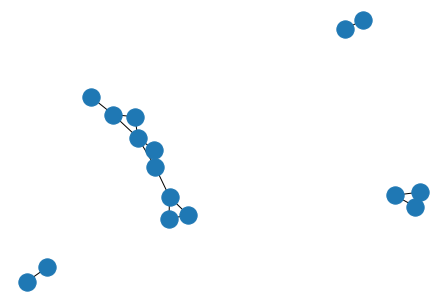

In [89]:

kw = KeywordGraph(data = df_tid,
                 node_column = 'keywords',
                 attributes = {'comment' : 'Customer Comments'},
                 nlp_object = nlp)
nx.draw(kw,with_labels=False)

##  TiddlyMap Class
This takes the graph and generates the JSON files necessary for the HTML file to display an interactive graph.

In [90]:
mytid = TiddlyMap(graph = kw,
                 text_attribute='comment')
mytid.build()
mytid.write_tiddler_file('tiddlers.json')

The thickness of the edge is proportional to co-occurence counts. The size of the nodes are proportional to the keyword counts.
You need to have a working knowledge of Tiddlywiki and Tiddlymap to use this (plenty of resources online)
<p>
<img src='tiddler_keyword_pic.png' width=500>

<img src='tiddler_page.png' width=500>

## Dimensional Reduction - interactive plot
We can look at how similar comments are and cluster them into a 2D plot. Here we use the UMAP-learn package.
We must be careful not to weight additional features over any other, so we can apply the 'zscore' function to any numerical variable (if there was one)


Let's look at the lemma comments and using word counts

In [91]:
df_umap =  (

      read_dataframe()
        .nlp_process_column(
            column_name = 'comment',
            nlp_object = nlp,
            new_column_name = 'nlp'
                            )
        .nlp_extract_pos(
            nlp_column = 'nlp',
            token_pos = ['NOUN'],
            new_column_name = 'nouns',
            lemma = True
                        )
        .nlp_extract_lemma_text(
            nlp_column = 'nlp',
            new_column_name = 'lemma_sentences',
            keep = ['neg']
        )
        .nlp_apply_tfidf(
                column_name = 'lemma_sentences',
                threshold = 0.2,
                top_n = 3,
                new_column_name = 'keywords',
                append=False)
        .transform_column('nouns', list_to_string)
        #.transform_column('keywords', set_to_string)
        .transform_column('good_week', lambda x: 'good_week' if x == 1 else 'bad_week', 'week_rating') #create a week_rating column
        .join_apply(lambda x: add_to_set(x['keywords'],x['week_rating']), 'keyword_rating') #first merge the keywords and the week_rating
    .transform_column('keywords', set_to_string, 'keywords')
    .nlp_process_column('nouns',nlp, 'nlp_nouns')
    .change_type('good_week', bool)
    .expand_column('person', " ")
    .change_type('family', bool)
    .change_type('solo', bool)
    .nlp_extract_sentiment('comment')
)

In [92]:
df_umap.head()

,person,good_week,comment,nlp,nouns,lemma_sentences,keywords,week_rating,keyword_rating,nlp_nouns,family,solo,sentiment
0,family,True,I really liked the dogs,"(I, really, liked, the, dogs)",dog,like dog,dog like,good_week,"{good_week, dog, like}",(dog),True,False,0.48
1,solo,True,wolves were fantastic,"(wolves, were, fantastic)",wolf,wolf fantastic,fantastic wolf,good_week,"{good_week, fantastic, wolf}",(wolf),False,True,0.56
2,family,True,cats were great,"(cats, were, great)",cat,cat great,great cat,good_week,"{good_week, great, cat}",(cat),True,False,0.62
3,solo,True,what amazing felines,"(what, amazing, felines)",feline,amazing feline,amazing feline,good_week,"{good_week, amazing, feline}",(feline),False,True,0.59
4,family,False,the food was not great,"(the, food, was, not, great)",food,food not great,not great food,bad_week,"{not, bad_week, great, food}",(food),True,False,-0.51


In [ ]:
create_umap_plot(df_umap,
                 text_column = 'nlp_nouns', # text columns that undergo some processing within this function
                 other_columns = ['sentiment'], #these would be numerical or boolean columns as normally passed into UMAP
                 filename = 'umap_example.html',
                 hover_columns = ['nouns' , 'sentiment'],
                 label = 'sentiment', #what to colour the plot by
                 label_categorical=False, #we have a numerical, not a categorical label
                 text_processing='vector', #we will use vector similarity to work out the distance between points
                 n_neighbours=2,
                 y = 'sentiment', #try to group data by sentiment
                 cmap='viridis',
                 background='black',
                 point_size = 12)


Here you can see the output plot, we trained it to separate based on sentiment, and using the extracted nouns. You can see positive sentiment is bottom left and negative top right.
And wolf is closer to dog than it is to cat (for example) showing how the word vectors have been used.
The plot is coloured by sentiment. The HTML plot is interactive and shows comments as you hover over

<img src='umap_plot.png' width=500>

# WordClouds
Everyone loves wordclouds. We can plot a single wordcloud or separate wordclouds based on a categorical column in the dataframe. E.g. if you want to see what words are associated with good weeks vs bad weeks

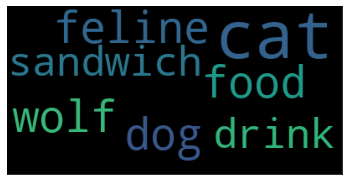

In [93]:
plot_wordcloud(df_umap,'nouns')

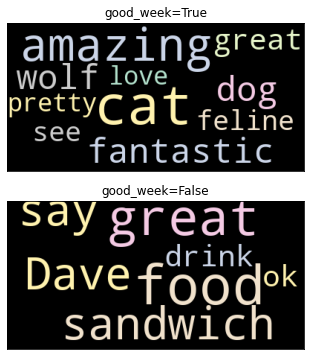

In [94]:
plot_wordcloud(df_umap,'lemma_sentences', row = 'good_week',background_color='black', colormap='Pastel2')

In [95]:
(
    read_dataframe()
    .nlp_process_column('comment',nlp)
    .nlp_extract_entities()
    .nlp_set_of_entities('entities',['PERSON'])
)

,person,good_week,comment,nlp,entities,entity_sets
0,family,1,I really liked the dogs,"(I, really, liked, the, dogs)",{},{}
1,solo,1,wolves were fantastic,"(wolves, were, fantastic)",{},{}
2,family,1,cats were great,"(cats, were, great)",{},{}
3,solo,1,what amazing felines,"(what, amazing, felines)",{},{}
4,family,0,the food was not great,"(the, food, was, not, great)",{},{}
5,solo,0,I didn't like the sandwiches,"(I, did, n't, like, the, sandwiches)",{},{}
6,solo,0,Dave said drinks were OK,"(Dave, said, drinks, were, OK)",{'PERSON': ['dave']},{dave}
7,family,1,"I saw a few cats when I was there and that was pretty amazing, I do love cats that's why!","(I, saw, a, few, cats, when, I, was, there, and, that, was, pretty, amazing, ,, I, do, love, cats, that, 's, why, !)",{},{}
